<a href="https://colab.research.google.com/github/walaaben20/pojet-big-data/blob/main/Projet_Big_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importation des bibliothèques nécessaires
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, length



In [2]:
# Création d'une session Spark
spark = SparkSession.builder \
    .appName("Healthcare Data Processing") \
    .getOrCreate()

In [3]:
#importation de drive
from google.colab import drive
drive.mount("/content/mydrive")


Mounted at /content/mydrive


In [4]:
data_path = "/content/mydrive/MyDrive/healthcare/healthcare_-_train.csv.csv"
data = spark.read.csv(data_path, header=True, inferSchema=True)

In [5]:
# Aperçu des données
data.show(5)
data.printSchema()

+----+--------------------+--------------------+
| _c0|              prompt|            response|
+----+--------------------+--------------------+
|NULL|Who is at risk fo...|LCMV infections c...|
|NULL|What are the symp...|LCMV is most comm...|
|NULL|Who is at risk fo...|Individuals of al...|
|NULL|How to diagnose L...|During the first ...|
|NULL|What are the trea...|Aseptic meningiti...|
+----+--------------------+--------------------+
only showing top 5 rows

root
 |-- _c0: string (nullable = true)
 |-- prompt: string (nullable = true)
 |-- response: string (nullable = true)



In [6]:
# Simplification du fichier : sélection des colonnes nécessaires (par exemple, 'prompt' et 'response')
simplified_data = data.select("prompt", "response")

In [7]:
# Suppression des doublons
simplified_data = simplified_data.dropDuplicates()

In [8]:
# Filtrage des lignes avec des longueurs de texte inférieures à 10 caractères
simplified_data = simplified_data.filter((length(col("prompt")) >= 10) & (length(col("response")) >= 10))

In [9]:
# Sauvegarde du fichier simplifié dans un nouveau fichier CSV
output_path = "/content/mydrive/MyDrive/healthcare/final_data.csv"
simplified_data.write.csv(output_path, header=True, mode="overwrite")
print("Final simplified data saved at", output_path)

Final simplified data saved at /content/mydrive/MyDrive/healthcare/final_data.csv


##Nettoyage et prétraitement des données


In [10]:
# Sélection des colonnes nécessaires
new_data = data.select("prompt", "response")

In [11]:
# Affichage des doublons globaux et sur une colonne spécifique
print("Doublons globaux :", new_data.dropDuplicates().count() - new_data.count())
print("Doublons dans 'prompt' :", new_data.dropDuplicates(["prompt"]).count() - new_data.count())

Doublons globaux : -12081
Doublons dans 'prompt' : -14173


In [12]:
# Suppression des doublons globaux
df = new_data.dropDuplicates()

In [13]:
# Suppression des doublons basés uniquement sur la colonne 'prompt'
df = df.dropDuplicates(["prompt"])

In [14]:
# Compter les valeurs manquantes
df.select([col(c).isNull().cast("int").alias(c + "_missing") for c in df.columns]).show()

+--------------+----------------+
|prompt_missing|response_missing|
+--------------+----------------+
|             1|               1|
|             0|               0|
|             0|               0|
|             0|               0|
|             0|               0|
|             0|               0|
|             0|               1|
|             0|               0|
|             0|               1|
|             0|               0|
|             0|               0|
|             0|               0|
|             0|               0|
|             0|               1|
|             0|               0|
|             0|               0|
|             0|               0|
|             0|               0|
|             0|               0|
|             0|               1|
+--------------+----------------+
only showing top 20 rows



In [15]:
# Suppression des lignes avec des longueurs de 'prompt' ou 'response' < 10
df = df.filter((length(col("prompt")) >= 10) & (length(col("response")) >= 10))

In [16]:
# Réinitialisation de l'index (non nécessaire avec PySpark, mais les données sont maintenant propres)
df.show()

+--------------------+--------------------+
|              prompt|            response|
+--------------------+--------------------+
| ""A 'rest time' ...| after it has bee...|
| 1 out of 90 Ashk...|     and 1 out of 30|
| 119 people with ...|700 treated with ...|
| 30 days) followi...| the first stage ...|
| 5% has been appr...| does not kill li...|
| Ancylostoma duod...| are worldwide in...|
| Ashkenazi Jews a...| are more likely ...|
|           Bilateral| and Cavitary Ret...|
| CDC estimates th...|000 persons with ...|
| CDC has develope...| hospital-based g...|
|    CK or CKMB tests| and serum myoglo...|
|  Causes of Diabetes| or by calling 18...|
|     Central America| and South Americ...|
|          Charleston|      South Carolina|
| DEC can cause se...| including enceph...|
| Dravet syndrome ...| febrile seizures...|
| For People of Af...|       Mediterranean|
|       HIV infection| a transplant or ...|
| High Blood Pressure|        and Diabetes|
| I will eat _____...| I will ea

##Ajout de nouvelles colonnes

In [17]:
# Importation de 'expr' depuis 'pyspark.sql.functions'
from pyspark.sql.functions import expr

# Ajout d'une colonne pour le nombre de mots dans chaque 'prompt'
df = df.withColumn("prompt_word_count", expr("size(split(prompt, ' '))"))

# Affichage du DataFrame après l'ajout de la colonne
df.show()


+--------------------+--------------------+-----------------+
|              prompt|            response|prompt_word_count|
+--------------------+--------------------+-----------------+
| ""A 'rest time' ...| after it has bee...|               16|
| 1 out of 90 Ashk...|     and 1 out of 30|               11|
| 119 people with ...|700 treated with ...|                9|
| 30 days) followi...| the first stage ...|                8|
| 5% has been appr...| does not kill li...|               32|
| Ancylostoma duod...| are worldwide in...|                6|
| Ashkenazi Jews a...| are more likely ...|                5|
|           Bilateral| and Cavitary Ret...|                2|
| CDC estimates th...|000 persons with ...|                7|
| CDC has develope...| hospital-based g...|                5|
|    CK or CKMB tests| and serum myoglo...|                5|
|  Causes of Diabetes| or by calling 18...|                4|
|     Central America| and South Americ...|                3|
|       

In [18]:
# Ajout d'une colonne pour le nombre de mots dans chaque 'response'
df = df.withColumn("response_word_count", expr("size(split(response, ' '))"))

In [19]:
df.show()

+--------------------+--------------------+-----------------+-------------------+
|              prompt|            response|prompt_word_count|response_word_count|
+--------------------+--------------------+-----------------+-------------------+
| ""A 'rest time' ...| after it has bee...|               16|                  9|
| 1 out of 90 Ashk...|     and 1 out of 30|               11|                  6|
| 119 people with ...|700 treated with ...|                9|                 25|
| 30 days) followi...| the first stage ...|                8|                 15|
| 5% has been appr...| does not kill li...|               32|                 69|
| Ancylostoma duod...| are worldwide in...|                6|                  7|
| Ashkenazi Jews a...| are more likely ...|                5|                 14|
|           Bilateral| and Cavitary Ret...|                2|                  4|
| CDC estimates th...|000 persons with ...|                7|                 35|
| CDC has develo

## Visualisation des données avec matplotlib

In [20]:
import matplotlib.pyplot as plt

In [21]:
# Conversion en Pandas pour visualisation
df_pd = df.toPandas()

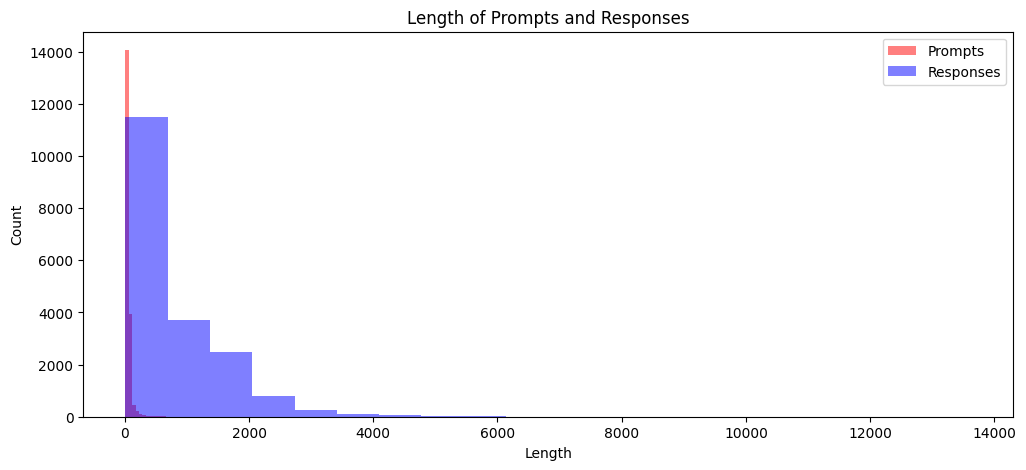

In [22]:
# Distribution des longueurs des 'prompt' et 'response'
plt.figure(figsize=(12, 5))
plt.hist(df_pd["prompt"].apply(len), bins=20, alpha=0.5, color="red", label="Prompts")
plt.hist(df_pd["response"].apply(len), bins=20, alpha=0.5, color="blue", label="Responses")
plt.legend()
plt.xlabel("Length")
plt.ylabel("Count")
plt.title("Length of Prompts and Responses")
plt.show()

Text(0.5, 1.0, 'Word Count Distribution')

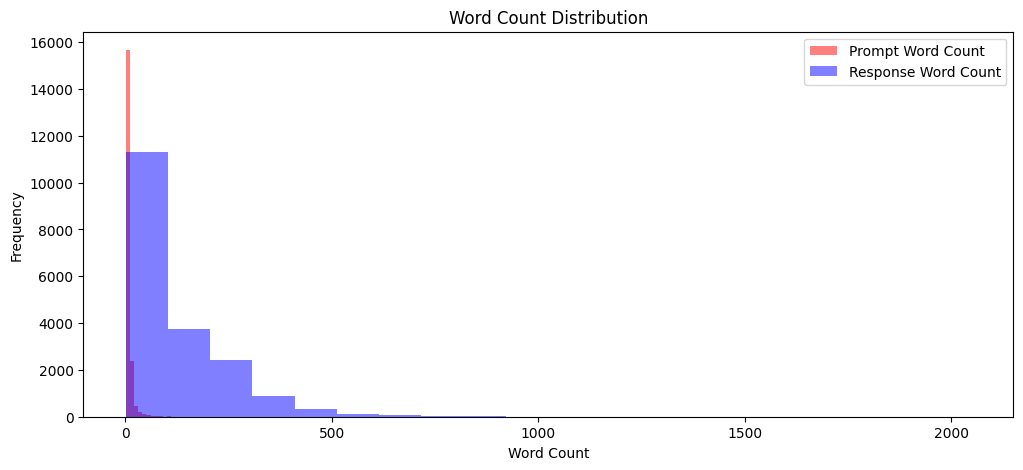

In [23]:
# Distribution des comptes de mots
plt.figure(figsize=(12, 5))
plt.hist(df_pd["prompt_word_count"], bins=20, alpha=0.5, color="red", label="Prompt Word Count")
plt.hist(df_pd["response_word_count"], bins=20, alpha=0.5, color="blue", label="Response Word Count")
plt.legend()
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.title("Word Count Distribution")

##Sauvegarde des données finales

In [24]:
# Sauvegarde du DataFrame final dans un fichier CSV
output_path = "/content/mydrive/MyDrive/healthcare/final_data.csv"
df.write.csv(output_path, header=True, mode="overwrite")

print("Final data saved at", output_path)

Final data saved at /content/mydrive/MyDrive/healthcare/final_data.csv


In [25]:
!pip install pyspark

In [26]:
#initialisez une session Spark pour pouvoir manipuler les données avec PySpark :
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

##Chargement et Prétraitement des Données avec PySpark

In [27]:
import os
print(os.getcwd())  # Affiche le répertoire courant

/content


In [28]:
import os
os.chdir('/content/mydrive/MyDrive/healthcare')  # Changez le répertoire de travail
print(os.getcwd())  # Vérifiez que vous êtes dans le bon répertoire

/content/mydrive/MyDrive/healthcare


In [29]:
import os
print(os.path.exists('final_data.csv'))  # Vérifie si le fichier existe

True


In [30]:
data_path = '/content/mydrive/MyDrive/healthcare/final_data.csv'
df_spark = spark.read.csv(data_path, header=True, inferSchema=True)


In [31]:
# Affichage des 10 premières lignes
df_spark.show(10)

+--------------------+--------------------+-----------------+-------------------+
|              prompt|            response|prompt_word_count|response_word_count|
+--------------------+--------------------+-----------------+-------------------+
|""A 'rest time' i...|after it has been...|               16|                  9|
|1 out of 90 Ashke...|     and 1 out of 30|               11|                  6|
|119 people with C...|700 treated with ...|                9|                 25|
|30 days) followin...|the first stage o...|                8|                 15|
|5% has been appro...|does not kill lic...|               32|                 69|
|Ancylostoma duode...|are worldwide in ...|                6|                  7|
|Ashkenazi Jews an...|are more likely t...|                5|                 14|
|           Bilateral|and Cavitary Reti...|                2|                  4|
|CDC estimates tha...|000 persons with ...|                7|                 35|
|CDC has develop

In [32]:
# Suppression des colonnes "prompt_word_count" et "response_word_count"
df_spark = df_spark.drop("prompt_word_count", "response_word_count")

In [33]:
# Affichage des 10 premières lignes après suppression
df_spark.show(10)

+--------------------+--------------------+
|              prompt|            response|
+--------------------+--------------------+
|""A 'rest time' i...|after it has been...|
|1 out of 90 Ashke...|     and 1 out of 30|
|119 people with C...|700 treated with ...|
|30 days) followin...|the first stage o...|
|5% has been appro...|does not kill lic...|
|Ancylostoma duode...|are worldwide in ...|
|Ashkenazi Jews an...|are more likely t...|
|           Bilateral|and Cavitary Reti...|
|CDC estimates tha...|000 persons with ...|
|CDC has developed...|hospital-based gu...|
+--------------------+--------------------+
only showing top 10 rows



In [34]:
# Échantillonnage aléatoire de 1500 lignes
df_sampled = df_spark.sample(False, 1500 / df_spark.count(), seed=42)

In [35]:
# Séparation en jeu d'entraînement et jeu de test (90/10)
train_df = df_sampled.sample(False, 0.9, seed=42)
test_df = df_sampled.exceptAll(train_df)

In [36]:
# Sauvegarde des datasets sous format JSONL pour être utilisés dans l'entraînement
train_df.write.json('train.jsonl', mode='overwrite')
test_df.write.json('test.jsonl', mode='overwrite')

##Traitement des Datasets avec PySpark

In [37]:
# Transformation des données en format texte pour l'entraînement
def process_data(row):
    system_message = "Hello! I'm here to provide concise information about general health problem, including their causes, symptoms, treatments, and recommended medications. How can I assist you today?"
    prompt = row['prompt']
    response = row['response']
    return {'text': f'[INST] <<SYS>>\n{system_message.strip()}\n<</SYS>>\n\n{prompt} [/INST] {response}'}

In [38]:
# Application de la transformation
train_rdd = train_df.rdd.map(process_data)
test_rdd = test_df.rdd.map(process_data)

In [39]:
# Conversion en DataFrame pour utilisation dans le fine-tuning
train_spark_df = spark.createDataFrame(train_rdd)
test_spark_df = spark.createDataFrame(test_rdd)

In [40]:
# Sauvegarde des datasets prétraités
train_spark_df.write.json('train_processed.jsonl', mode='overwrite')
test_spark_df.write.json('test_processed.jsonl', mode='overwrite')

##Chargement et Fine-Tuning du Modèle

In [41]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [42]:
#importation de load datasets
from datasets import load_dataset

In [43]:
#verification de la presence exacte de fichier
import os

file_path = '/content/train_processed.jsonl'
if os.path.exists(file_path):
    print(f"File found: {file_path}")
else:
    print(f"File not found: {file_path}")

File found: /content/train_processed.jsonl


In [44]:
#affichage de fichiers existant dans content
import os
print(os.listdir('/content/'))

['.config', 'train_processed.jsonl', 'test_processed.jsonl', 'test.jsonl', 'train.jsonl', 'mydrive', 'sample_data']


In [45]:
import os

file_path = '/content/train_processed.jsonl'

if os.path.isfile(file_path):
    print(f"{file_path} is a valid file.")
elif os.path.isdir(file_path):
    print(f"{file_path} is a directory!")
else:
    print(f"{file_path} does not exist or is not a file.")


/content/train_processed.jsonl is a directory!


In [46]:
import shutil

directory_path = '/content/train_processed.jsonl'

if os.path.isdir(directory_path):
    print(f"Supprimons le répertoire : {directory_path}")
    shutil.rmtree(directory_path)  # Supprime le répertoire et son contenu
else:
    print(f"{directory_path} n'est pas un répertoire.")

Supprimons le répertoire : /content/train_processed.jsonl


In [47]:
# Exemple de création d'un fichier JSONL minimal
data = [
    {"prompt": "What is asthma?", "response": "Asthma is a chronic respiratory condition."},
    {"prompt": "How to treat a headache?", "response": "Common treatments include rest and over-the-counter pain relievers."}
]

import json

file_path = '/content/train_processed.jsonl'

with open(file_path, 'w') as f:
    for record in data:
        f.write(json.dumps(record) + '\n')

print(f"Fichier créé : {file_path}")

Fichier créé : /content/train_processed.jsonl


In [48]:
#recharge de donnees
from datasets import load_dataset

train_dataset = load_dataset('json', data_files='/content/train_processed.jsonl', split="train")
print(train_dataset)


Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['prompt', 'response'],
    num_rows: 2
})


In [49]:
train_dataset = load_dataset('json', data_files='/content/train_processed.jsonl', split="train")
valid_dataset = load_dataset('json', data_files='/content/train_processed.jsonl', split="train")

In [50]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.1/320.1 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 52.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.8/63.8 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 9.8 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2


In [51]:
!pip install transformers accelerate

In [52]:
!pip install transformers torch gradio

In [53]:
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf
from google.colab import drive

In [54]:
from pyspark.sql import SparkSession

# Créez la session Spark et chargez le fichier
spark = SparkSession.builder.master("local[*]").appName("Healthcare Chatbot").getOrCreate()
data_path = "/content/mydrive/MyDrive/healthcare/final_data.csv"
df = spark.read.csv(data_path, header=True, inferSchema=True)

# Convertir le DataFrame en Pandas pour plus de flexibilité
df_pd = df.toPandas()

# Vérifier les 5 premières lignes du fichier
print(df_pd.head())


                                              prompt  \
0  ""A 'rest time' is the amount of time the prod...   
1        1 out of 90 Ashkenazi Jews is an FA carrier   
2               119 people with CJD were among the 1   
3         30 days) following an infected tick's bite   
4  5% has been approved by the FDA for the treatm...   

                                            response  prompt_word_count  \
0             after it has been removed from a grill                 16   
1                                    and 1 out of 30                 11   
2  700 treated with pituitary hGH. The pattern of...                  9   
3  the first stage of Lyme disease may begin with...                  8   
4  does not kill lice eggs). A second treatment i...                 32   

   response_word_count  
0                    9  
1                    6  
2                   25  
3                   15  
4                   69  


In [55]:
from transformers import AutoTokenizer

# Charger le tokenizer
tokenizer = AutoTokenizer.from_pretrained("microsoft/DialoGPT-medium")

# Définir le pad_token
tokenizer.pad_token = tokenizer.eos_token  # Utiliser eos_token comme pad_token

# OU vous pouvez ajouter un pad_token personnalisé
# tokenizer.add_special_tokens({'pad_token': '[PAD]'})

def tokenize_function(examples):
    # Concaténer 'prompt' et 'response' pour chaque entrée
    texts = [f"[INST] <<SYS>>\n{prompt} [/INST] {response}"
             for prompt, response in zip(examples['prompt'], examples['response'])]

    # Utilisation du tokenizer pour transformer le texte
    return tokenizer(texts, truncation=True, max_length=512, padding="max_length")

# Appliquer la fonction de tokenisation sur le dataset entier
tokenized_train = train_dataset.map(tokenize_function, batched=True)

# Vérification après la tokenisation
print(tokenized_train[0])



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

Map:   0%|          | 0/2 [00:00<?, ? examples/s]

{'prompt': 'What is asthma?', 'response': 'Asthma is a chronic respiratory condition.', 'input_ids': [58, 38604, 60, 9959, 50, 16309, 4211, 198, 2061, 318, 28438, 30, 46581, 38604, 60, 8304, 21720, 318, 257, 10726, 22949, 4006, 13, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256

In [56]:
from transformers import AutoModelForCausalLM, Trainer, TrainingArguments
import torch

# Charger le modèle pré-entraîné
model = AutoModelForCausalLM.from_pretrained("microsoft/DialoGPT-medium")

# Préparer les arguments d'entraînement
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    logging_dir="./logs",
    logging_steps=10,
    save_steps=100,  # Sauvegarde après 100 steps
    evaluation_strategy="steps",  # Évaluation après 100 steps
    eval_steps=100,  # Définir les steps pour l'évaluation
    warmup_steps=500,
    weight_decay=0.01,
    save_total_limit=2,
    load_best_model_at_end=True,  # Charger le meilleur modèle à la fin
)





config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/863M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [57]:
# Assurez-vous que Spark est configuré et les données sont chargées
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# Initialiser la session Spark
spark = SparkSession.builder.appName("Healthcare Chatbot").getOrCreate()

# Charger les données de final_data.csv
data_path = "/content/mydrive/MyDrive/healthcare/final_data (1).csv/final_data.csv"
df = spark.read.csv(data_path, header=True, inferSchema=True)
# Convertir en DataFrame Pandas pour une recherche plus facile
df_pd = df.toPandas()

In [58]:
# Vérifier l'état de votre GPU (optionnel)
!nvidia-smi

Tue Dec  3 09:40:35 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8              11W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [59]:
# Importer les bibliothèques nécessaires
import gradio as gr
import random
import time
import numpy as np
from transformers import AutoTokenizer
import transformers
import torch

In [60]:
from transformers import pipeline

# Initialisation du pipeline avec un modèle de conversation
pipe = pipeline("text-generation", model="microsoft/DialoGPT-medium")

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [61]:
print(train_dataset[0])  # Afficher le premier exemple
print(train_dataset[1])  # Afficher le deuxième exemple


{'prompt': 'What is asthma?', 'response': 'Asthma is a chronic respiratory condition.'}
{'prompt': 'How to treat a headache?', 'response': 'Common treatments include rest and over-the-counter pain relievers.'}


In [62]:
def chat_response(message):
    system_message = "Welcome! You're now communicating with an AI model trained to assist with information about general health disease. Feel free to ask about causes, symptoms, medications, and treatment options!"
    prompt = f"{system_message}\n\n{message}"  # Définir prompt ici à partir du message de l'utilisateur

    # Générer une réponse avec troncation activée et ajustements pour éviter la répétition
    sequences = pipe(
        prompt,
        do_sample=True,
        top_k=50,
        num_return_sequences=1,
        max_length=200,
        temperature=0.5,
        no_repeat_ngram_size=2,
        truncation=True  # Ajout explicite de la troncation
    )

    # Récupérer la réponse générée et supprimer les balises indésirables
    bot_message = sequences[0]['generated_text']

    # Nettoyer la sortie en enlevant les balises
    bot_message = bot_message.replace('[INST] ', '').replace(' [/INST]', '').replace('<SYS>', '').replace('</SYS>', '')

    # Supprimer tout texte indésirable (exemple : questions répétitives ou réponses incohérentes)
    bot_message = bot_message.split("The following")[0]  # On coupe la réponse au premier passage de "The following"

    return bot_message.strip()  # Supprimer les espaces superflus

# Fonction qui traite le message de l'utilisateur
def respond(message, chat_history):
    bot_message = chat_response(message)  # Utiliser le message de l'utilisateur pour générer une réponse

    # Ajouter les messages sous forme de dictionnaires avec 'role' et 'content'
    chat_history.append({"role": "user", "content": message})
    chat_history.append({"role": "assistant", "content": bot_message})

    return "", chat_history

In [63]:
# Interface Gradio pour le chatbot
with gr.Blocks() as demo:
    chatbot = gr.Chatbot(label="Personal Health Assistant", type='messages')  # Spécifier 'messages' pour le type
    msg = gr.Textbox()
    clear = gr.ClearButton([msg, chatbot])

    def respond(message, chat_history):
        bot_message = chat_response(message)

        # Ajouter les messages sous forme de dictionnaires avec 'role' et 'content'
        chat_history.append({"role": "user", "content": message})
        chat_history.append({"role": "assistant", "content": bot_message})

        return "", chat_history

    msg.submit(respond, [msg, chatbot], [msg, chatbot])

# Lancer l'application
demo.launch(share=True, debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://a3663d6d0bf3a08397.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://a3663d6d0bf3a08397.gradio.live
